In [1]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

from sumpy.recurrence import get_recurrence

import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [2]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)
n_init_lap, order_lap, recur_laplace = get_processed_and_shifted_recurrence(laplace2d)

w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w
n_init_helm, order_helm, recur_helmholtz = get_processed_and_shifted_recurrence(helmholtz2d)

In [3]:
max_abs = .0000001
var = _make_sympy_vec("x", 2)
rct = sp.symbols("r_{ct}")
s = sp.Function("s")
n = sp.symbols("n")

In [4]:
def compute_derivatives(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                        for i in range(p)]
    return derivs
l_max = 15
derivs_laplace = compute_derivatives(l_max)

In [5]:
def compute_derivatives_h2d(p):
    k = 1
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                        (var[1]-var_t[1])**2)
    g_x_y = (1j/4) * hankel1(0, k * abs_dist)
    derivs_helmholtz = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                                for i in range(p)]
    return derivs_helmholtz
h_max = 8
derivs_helmholtz = compute_derivatives_h2d(h_max)

In [5]:
def evaluate_recurrence_lamb(coord_dict, recur, p, derivs_list, n_initial, n_order):
    subs_dict = {}
    for i in range(n_initial-n_order, 0):
        subs_dict[s(i)] = 0
    for i in range(n_initial):
        subs_dict[s(i)] = derivs_list[i].subs(coord_dict)
    var = _make_sympy_vec("x", 2)
    for i in range(n_initial, p):
        exp = get_recurrence(recur, i)
        f = sp.lambdify([var[0], var[1]] + [s(i-(1+k)) for k in range(n_order-1)], exp)
        subs_dict[s(i)] = f(*([coord_dict[var[0]], coord_dict[var[1]]] + [subs_dict[s(i-(1+k))] for k in range(n_order-1)]))
    for i in range(n_initial-n_order, 0):
        subs_dict.pop(s(i))
    return np.array(list(subs_dict.values()))

In [6]:
def evaluate_true(coord_dict, p, derivs_list):
    retMe = []
    for i in range(p):
        exp = derivs_list[i]
        f = sp.lambdify(var, exp)
        retMe.append(f(coord_dict[var[0]], coord_dict[var[1]]))
    return np.array(retMe)

In [7]:
def compute_error_coord(recur, loc, order, derivs_list, n_initial, n_order):
    var = _make_sympy_vec("x", 2)
    coord_dict = {var[0]: loc[0], var[1]: loc[1]}

    exp = evaluate_recurrence_lamb(coord_dict, recur, order+1, derivs_list, n_initial, n_order)[order].evalf()
    
    true = derivs_list[order].subs(coord_dict).evalf()

    

    return (np.abs(exp-true)/np.abs(true))

In [8]:
def generate_error_grid(res, order_plot, recur, derivs, n_initial, n_order):
    x_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
    y_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
    res=len(x_grid)
    plot_me = np.empty((res, res))
    for i in range(res):
        for j in range(res):
            if abs(x_grid[i]) == abs(y_grid[j]):
                plot_me[i, j] = 1e-16
            else:
                plot_me[i,j] = compute_error_coord(recur, np.array([x_grid[i],y_grid[j]]), order_plot, derivs, n_initial, n_order)
                if plot_me[i,j] == 0:
                    plot_me[i, j] = 1e-16
    return x_grid, y_grid, plot_me

In [ ]:
order_plot = 5
x_grid, y_grid, plot_me_hem = generate_error_grid(res=5, order_plot=order_plot, recur=recur_helmholtz, derivs=derivs_helmholtz, n_initial=n_init_helm, n_order=order_helm)
x_grid, y_grid, plot_me_lap  = generate_error_grid(res=5, order_plot=order_plot, recur=recur_laplace, derivs=derivs_laplace, n_initial=n_init_lap, n_order=order_lap)
                
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
cs = ax1.contourf(x_grid, y_grid, plot_me_hem.T, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)

cs = ax2.contourf(x_grid, y_grid, plot_me_lap.T, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("source x-coord")
ax1.set_ylabel("source y-coord")


ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("source x-coord")
ax2.set_ylabel("source y-coord")

ax1.set_title("Helmholtz recurrence relative error for order = "+str(order_plot))
ax2.set_title("Laplace recurrence relative error for order = "+str(order_plot))

fig.savefig('order'+str(order_plot))
plt.show()

/var/folders/8s/7hlc6ky15zzflj9wcf92cdxh0000gn/T/ipykernel_14919/1312385240.py:6: UserWarning: Log scale: values of z <= 0 have been masked
  cs1 = ax1.contourf(x_grid, y_grid, plot_me_lap.T < 1e-5, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
/var/folders/8s/7hlc6ky15zzflj9wcf92cdxh0000gn/T/ipykernel_14919/1312385240.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  cs2 = ax2.contourf(x_grid, y_grid, plot_me_hem.T < 1e-5, locator=ticker.LogLocator(), cmap=cm.PuBu_r)


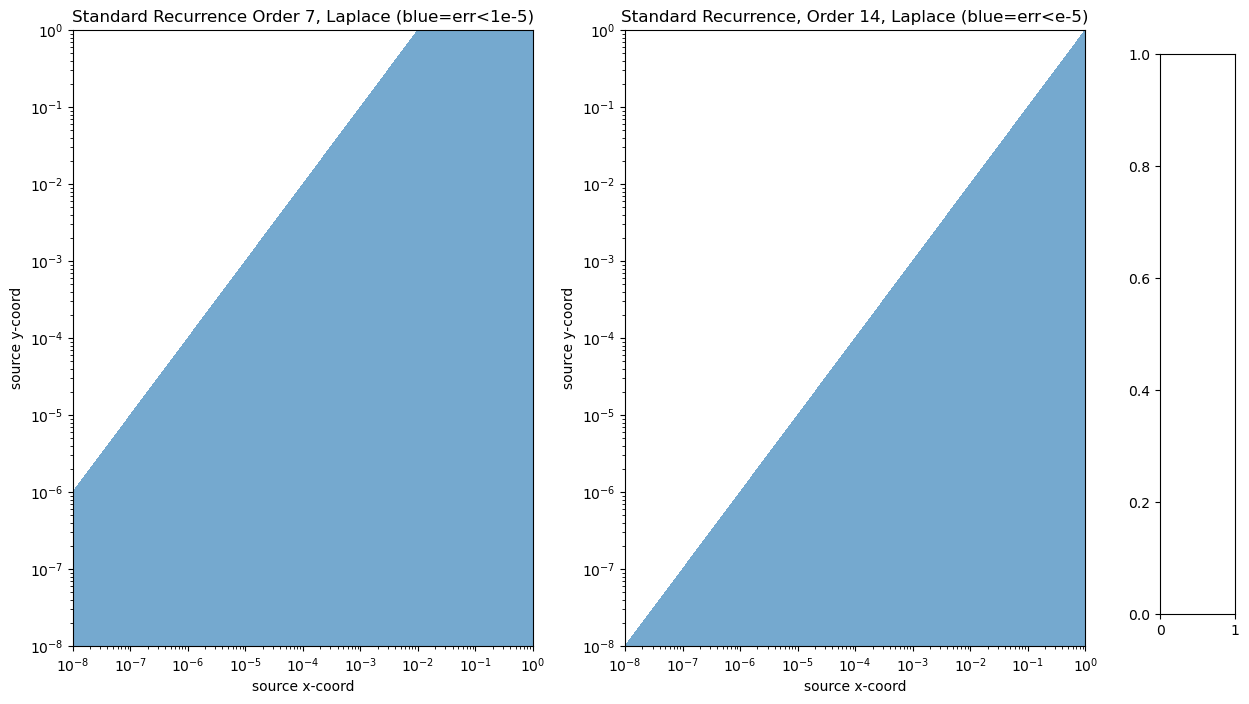

In [17]:
order_plot = 7
x_grid, y_grid, plot_me_hem = generate_error_grid(res=5, order_plot=2*order_plot, recur=recur_laplace, derivs=derivs_laplace, n_initial=n_init_lap, n_order=order_lap)
x_grid, y_grid, plot_me_lap  = generate_error_grid(res=5, order_plot=order_plot, recur=recur_laplace, derivs=derivs_laplace, n_initial=n_init_lap, n_order=order_lap)
                
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
cs1 = ax1.contourf(x_grid, y_grid, plot_me_lap.T < 1e-5, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cs2 = ax2.contourf(x_grid, y_grid, plot_me_hem.T < 1e-5, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(cs1, cax=cbar_ax)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("source x-coord")
ax1.set_ylabel("source y-coord")


ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("source x-coord")
ax2.set_ylabel("source y-coord")

ax1.set_title('Standard Recurrence Order 7, Laplace (blue=err<1e-5)')
ax2.set_title('Standard Recurrence, Order 14, Laplace (blue=err<e-5)')

plt.show()

/var/folders/8s/7hlc6ky15zzflj9wcf92cdxh0000gn/T/ipykernel_14919/1892395105.py:6: UserWarning: Log scale: values of z <= 0 have been masked
  cs1 = ax1.contourf(x_grid, y_grid, plot_me_lap.T < 1e-5, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
/var/folders/8s/7hlc6ky15zzflj9wcf92cdxh0000gn/T/ipykernel_14919/1892395105.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  cs2 = ax2.contourf(x_grid, y_grid, plot_me_hem.T < 1e-5, locator=ticker.LogLocator(), cmap=cm.PuBu_r)


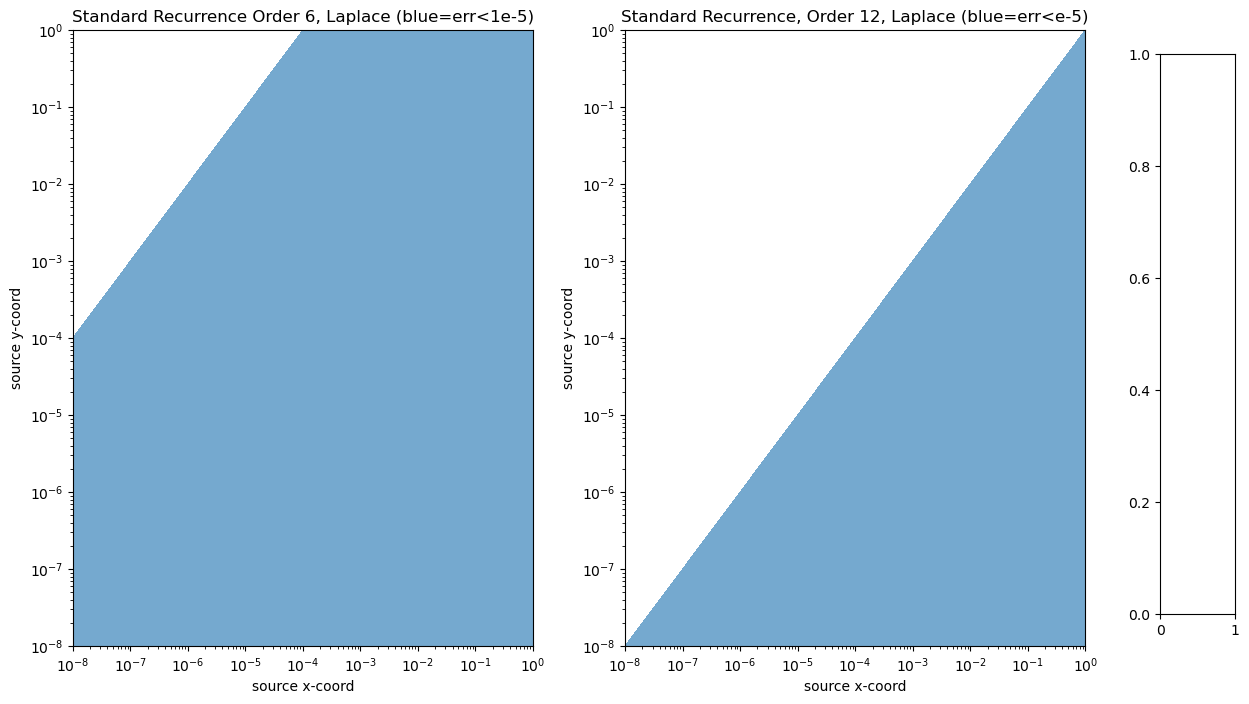

In [18]:
order_plot = 6
x_grid, y_grid, plot_me_hem = generate_error_grid(res=5, order_plot=2*order_plot, recur=recur_laplace, derivs=derivs_laplace, n_initial=n_init_lap, n_order=order_lap)
x_grid, y_grid, plot_me_lap  = generate_error_grid(res=5, order_plot=order_plot, recur=recur_laplace, derivs=derivs_laplace, n_initial=n_init_lap, n_order=order_lap)
                
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
cs1 = ax1.contourf(x_grid, y_grid, plot_me_lap.T < 1e-5, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cs2 = ax2.contourf(x_grid, y_grid, plot_me_hem.T < 1e-5, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(cs1, cax=cbar_ax)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("source x-coord")
ax1.set_ylabel("source y-coord")


ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("source x-coord")
ax2.set_ylabel("source y-coord")

ax1.set_title('Standard Recurrence Order 6, Laplace (blue=err<1e-5)')
ax2.set_title('Standard Recurrence, Order 12, Laplace (blue=err<e-5)')

plt.show()

In [ ]:
recur_laplace

In [ ]:
orders_odd = [i for i in range(6, l_max, 2)]
err1 = []
err2 = []
for o in orders_odd:
    err1.append(compute_error_coord(recur_laplace, np.array([1e-4, 1]), o, derivs_laplace, n_init_lap, order_lap))
    err2.append(compute_error_coord(recur_laplace, np.array([1e-8, 1]), o, derivs_laplace, n_init_lap, order_lap))

orders_odd = np.array(orders_odd)
err1 = np.array(err1, dtype=float)
err2 = np.array(err2, dtype=float)

coefficients1 = np.polyfit(np.log10(orders_odd), np.log10(err1), 1)
coefficients2 = np.polyfit(np.log10(orders_odd), np.log10(err2), 1)
polynomial1 = np.poly1d(coefficients1)
log10_y_fit1 = polynomial1(np.log10(orders_odd))
plt.plot(orders_odd, 10**log10_y_fit1, '*-')
plt.scatter(orders_odd, err1, label='1e-4')

polynomial2 = np.poly1d(coefficients2)
log10_y_fit2 = polynomial2(np.log10(orders_odd))
plt.plot(orders_odd, 10**log10_y_fit2, '*-')
plt.scatter(orders_odd, err2, label='1e-8')
plt.xscale('log')
plt.yscale('log')
plt.title("Rel Error vs Order Laplace 2D (Even Derivatives Only)")
plt.legend()

In [ ]:
err1 = []
err2 = []
orders_odd = [i for i in range(5, l_max, 2)]

for o in orders_odd:
    err1.append(compute_error_coord(recur_laplace, np.array([1e-4, 1]), o, derivs_laplace, n_init_lap, order_lap))
    err2.append(compute_error_coord(recur_laplace, np.array([1e-8, 1]), o, derivs_laplace, n_init_lap, order_lap))

orders_even = np.array(orders_odd)
err1 = np.array(err1, dtype=float)
err2 = np.array(err2, dtype=float)

coefficients1 = np.polyfit(np.log10(orders_even), np.log10(err1), 1)
coefficients2 = np.polyfit(np.log10(orders_even), np.log10(err2), 1)
polynomial1 = np.poly1d(coefficients1)
log10_y_fit1 = polynomial1(np.log10(orders_even))
plt.plot(orders_even, 10**log10_y_fit1, '*-')
plt.scatter(orders_even, err1, label='1e-4')

polynomial2 = np.poly1d(coefficients2)
log10_y_fit2 = polynomial2(np.log10(orders_even))
plt.plot(orders_even, 10**log10_y_fit2, '*-')
plt.scatter(orders_even, err2, label='1e-8')
plt.xscale('log')
plt.yscale('log')
plt.title("Rel. Error vs Order Laplace 2D (Odd Derivatives Only)")
plt.legend()

In [14]:
def get_slope(loc, orders):
    err = []
    for o in orders:
        err.append(compute_error_coord(recur_laplace, loc, o, derivs_laplace, n_init_lap, order_lap))
    
    err = np.array(err, dtype=float)
    coefficients = np.polyfit(np.log10(orders), np.log10(err), 1)

    return coefficients[0]

In [15]:
ratios = np.array([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
slopes = []
for r in ratios:
    slopes.append(get_slope(np.array([r, 1]), np.array([i for i in range(6, l_max, 2)])))

In [ ]:
plt.scatter(ratios, slopes)
plt.xscale('log')
plt.title("Slope of Best Fit vs ratio of y0/x0 for even derivatives")

In [17]:
coefficients_new = np.polyfit(np.log10(ratios), slopes, 1)

In [ ]:
coefficients_new